In [1]:
import os
import json
import glob
import cv2
import evaluate

c:\Users\Wathunyu\anaconda3\envs\hf_vision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'test')))

In [3]:
from LLaVADentist import LLaVADentist
from CreateSummaryHeatMap import CreateHeatMap
from CreateRougeScore import CreateRougeMatrix

In [4]:
# --- การตั้งค่า ---
BASE_MODEL_PATH = "llava-1.5-7b-hf-bnb-4bit"
ADAPTER_PATH = "adapter"

EVAL_DATA_DIR = "evaluation_dataset/anterior_teeth/"
OUTPUT_DIR = "evaluation_results/"
INSTRUCTION = "You are an expert specializing in dentistry. Describe the condition of the anterior teeth in this dentistry with clinical accuracy, mentioning any anatomy, pathology, or restorations."

In [5]:
# --- เตรียมโฟลเดอร์สำหรับเก็บผลลัพธ์ ---
results_json_dir = os.path.join(OUTPUT_DIR, "results_json")
heatmaps_dir = os.path.join(OUTPUT_DIR, "heatmaps")
os.makedirs(results_json_dir, exist_ok=True)
os.makedirs(heatmaps_dir, exist_ok=True)

# --- โหลดโมเดลและ Metric ---
print("Initializing the model with PEFT...")
model = LLaVADentist(BASE_MODEL_PATH, ADAPTER_PATH)

print("Loading ROUGE metric...")
rouge_metric = evaluate.load('rouge')
print("-" * 30)
print("Model and metrics are loaded and ready.")

Initializing the model with PEFT...
Initializing model with PEFT on device: cuda


c:\Users\Wathunyu\anaconda3\envs\hf_vision\lib\site-packages\transformers\models\auto\modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
c:\Users\Wathunyu\anaconda3\envs\hf_vision\lib\site-packages\transformers\quantizers\auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Applying critical fix to multi_modal_projector...
Fix applied.
PEFT model initialized successfully.
Loading ROUGE metric...
------------------------------
Model and metrics are loaded and ready.


## ขั้นตอนที่ 3: ประมวลผลข้อมูลทดสอบทั้งหมด

เซลล์นี้จะวนลูปอ่านไฟล์ `.json` ในชุดข้อมูลทดสอบ, รันโมเดลเพื่อสร้างผลลัพธ์, และบันทึกข้อมูลทั้งหมดลงในโฟลเดอร์ `test/evaluation_results/results_json/`
**ขั้นตอนนี้ขึ้นอยู่กับจำนวนเคสทดสอบและประสิทธิภาพของ GPU**

In [6]:
# --- ค้นหาและประมวลผลข้อมูลทดสอบทีละเคส ---
ground_truth_files = glob.glob(os.path.join(EVAL_DATA_DIR, "*.json"))
if not ground_truth_files:
    print(f"Error: No ground truth .json files found in '{EVAL_DATA_DIR}'.")
else:
    print(f"Found {len(ground_truth_files)} evaluation cases.")

    for gt_path in ground_truth_files:
        case_name = os.path.splitext(os.path.basename(gt_path))[0]
        print(f"\n--- Processing case: {case_name} ---")
        with open(gt_path, 'r', encoding='utf-8') as f: ground_truth = json.load(f)
        image_path = ground_truth.get("image_path")
        if not image_path or not os.path.exists(image_path):
            print(f"Warning: Image path for '{case_name}' not found. Skipping.")
            continue
        
        print("Generating narrative...")
        generated_narrative = model.generate_narrative(image_path, INSTRUCTION)

        # --- การคำนวณและเก็บข้อมูล ---
        rouge_scores = {}
        expert_narrative = ground_truth.get("expert_narrative", "")
        if "Error:" not in generated_narrative and expert_narrative:
            print("Calculating ROUGE scores...")
            scores = rouge_metric.compute(
                predictions=[generated_narrative],
                references=[expert_narrative]
            )
            rouge_scores = scores
            print(f"ROUGE Scores: {scores}")

        # (ส่วนสร้าง XAI Heatmap)
        xai_explanations = {}
        if "Error:" not in generated_narrative:
            print(f"Generated Narrative: {generated_narrative}")
            print("Generating XAI heatmaps...")
            full_xai_prompt = f"USER: <image>\n{INSTRUCTION}\nASSISTANT: {generated_narrative}"
            keywords_in_narrative = generated_narrative.lower()
            expected_keywords = ground_truth.get("key_keywords_expected", [])
            all_keywords_to_check = set(expected_keywords) | {word.strip(".,!?") for word in keywords_in_narrative.split()}
            relevant_keywords = ["anterior", "bone", "canine", "central incisor", "crown", "fracture", "incisor", "lateral incisor", "lesion", "loss", "mandibular", "maxillary", "normal", "pathology", "periapical", "restoration", "untreated"]
            keywords_to_generate_heatmap_for = [kw for kw in relevant_keywords if kw in all_keywords_to_check]
            print(f"Keywords for heatmap generation: {keywords_to_generate_heatmap_for}")
            for keyword in keywords_to_generate_heatmap_for:
                was_mentioned = keyword in keywords_in_narrative
                print(f" - Generating for keyword: '{keyword}' (Mentioned: {was_mentioned})")
                heatmap = model.generate_xai_heatmap(image_path, full_xai_prompt, keyword)
                if heatmap is not None:
                    suffix = "" if was_mentioned else "_omitted"
                    heatmap_filename = f"{case_name}_heatmap_{keyword}{suffix}.jpg"
                    heatmap_path = os.path.join(heatmaps_dir, heatmap_filename)
                    cv2.imwrite(model.superimpose_heatmap(image_path, heatmap), heatmap_path)
                    xai_explanations[keyword] = {"path": heatmap_path, "mentioned_in_narrative": was_mentioned}
                else: print(f"   - Failed to generate heatmap for '{keyword}'")
        else:
             print(f"Failed to generate narrative: {generated_narrative}")
             print("Skipping XAI heatmap generation.")

        # --- การบันทึกผลลัพธ์ ---
        result_data = {
            "case_name": case_name, "image_path": image_path, "ground_truth_path": gt_path,
            "analysis_focus": ground_truth.get("analysis_focus", "N/A"),
            "generated_narrative": generated_narrative,
            "expert_narrative": expert_narrative,
            "rouge_scores": rouge_scores,
            "xai_explanations": xai_explanations
        }
        result_filename = f"{case_name}_result.json"
        result_path = os.path.join(results_json_dir, result_filename)
        with open(result_path, 'w', encoding='utf-8') as f: json.dump(result_data, f, indent=2, ensure_ascii=False)
        print(f"Saved results for {case_name} to {result_path}")
    
    print("\nEvaluation run completed.")

Found 2 evaluation cases.

--- Processing case: case_001 ---
Generating narrative...
DEBUG: Raw model output: '<s> USER: <image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><ima

## ขั้นตอนที่ 4: สร้าง Visualization สรุปผล

หลังจากที่ข้อมูลทั้งหมดถูกสร้างและบันทึกเรียบร้อยแล้ว เซลล์นี้จะเรียกใช้สคริปต์ย่อยเพื่อสร้าง Heatmap สรุปผล 2 แบบ:
1.  **Model Performance Summary:** แสดงผลการตรวจจับ Keyword (Mentioned/Omission)
2.  **ROUGE Score Performance Matrix:** แสดงผลคะแนน ROUGE score ของแต่ละเคส


--- Generating Summary Heatmap ---

--- Generating Final Summary Heatmap ---


c:\Users\Wathunyu\Documents\GitHub\XAI-MINI\test\CreateSummaryHeatMap.py:63: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_labels = heatmap_df.applymap(lambda x: score_labels.get(x, ""))



Summary heatmap saved to 'evaluation_results\heatmaps/evaluation_summary_heatmap.png'


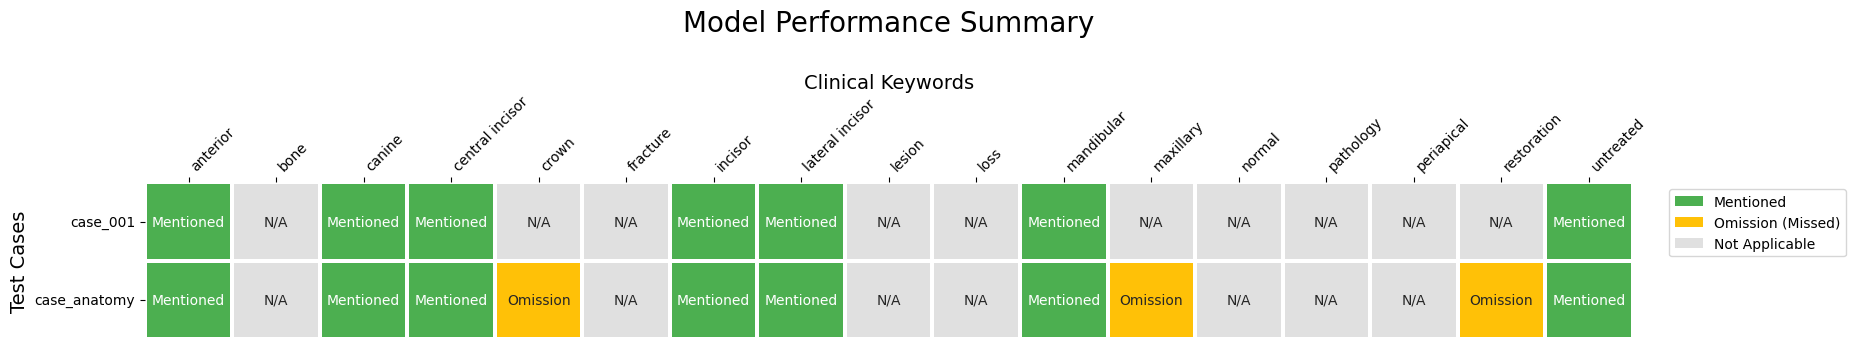

In [8]:
# --- สร้าง Heatmap สรุปผล Keyword ---
print("\n--- Generating Summary Heatmap ---")
CreateHeatMap(results_json_dir)


--- Generating ROUGE Score Matrix ---
Initialized ROUGE Matrix Creator.
Found 2 result files. Extracting ROUGE scores...

Generating ROUGE score heatmap...
ROUGE score heatmap saved to 'evaluation_results\rouge_scores_heatmap.png'


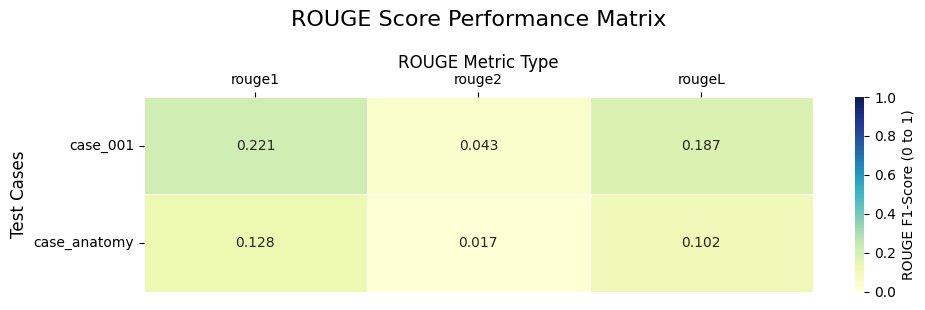


All visualizations have been generated and saved.


In [9]:
# --- สร้าง Heatmap ของ ROUGE Score ---
print("\n--- Generating ROUGE Score Matrix ---")
rouge_matrix_creator = CreateRougeMatrix(results_json_dir)
rouge_matrix_creator.generate()

print("\nAll visualizations have been generated and saved.")